# CIFAR-10 Image Classification

## Table of Contents
- [Introduction](#introduction)
- [Import the dataset](#import-the-dataset)
- [Investigate and preprocess the dataset](#investigate-and-preprocess-the-dataset)
- [Evaluating model performance](#evaluating-model-performance)
- [Build a simple neural network](#build-a-simple-neural-network)

## Introduction <a class="anchor" id="introduction"></a>

In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import numpy as np

## Import the dataset <a class="anchor" id="import-the-dataset"></a>

Import the CIFAR-10 dataset from Keras using the load_data function and one-hot encode the labels

In [177]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

## Investigate and preprocess the dataset <a class="anchor" id="investigate-and-preprocess-the-dataset"></a>

Investigate the properties of the training and test data

In [122]:
print(f"Number of training data rows: {x_train.shape[0]}")
print(f"Number of test data rows: {x_test.shape[0]}")
print(f'Resolution of each image: {x_train.shape[1]} x {x_train.shape[2]}')
print(f'Number of channels: {x_train.shape[3]}')
print(f'Number of classes: {len(np.unique(y_train))}')

Number of training data rows: 50000
Number of test data rows: 10000
Resolution of each image: 32 x 32
Number of channels: 3
Number of classes: 10


We can see that there are 50,000 training images and 10,000 test images meaning that the dataset is split into ~83% training and ~17% test data. Each image is 32x32 pixels with 3 channels (RGB).

In order to effectively compare the models, we need to create a validation set. In this case, we will take 20% of the training set as the validation set.

In [180]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2)

Display an image corresponding to each of the 10 classes using matplotlib

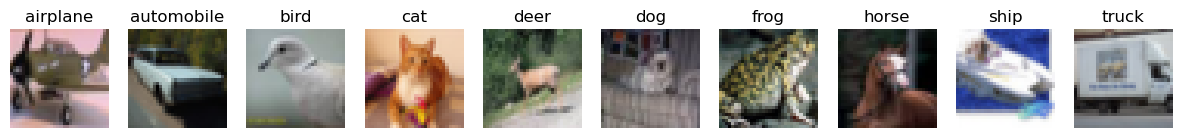

In [181]:
target_names = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

figure, axis = plt.subplots(1, 10, figsize=(15, 1.5))
for i in range(len(target_names)):
    index = np.argmax(y_train, axis=1) == i
    index = np.argmax(index)
    axis[i].imshow(x_train[index])
    axis[i].set_title(target_names[i])
    axis[i].axis('off')
plt.show()

As the images use the RGB colour model, the pixel values for each image are positive integers in the range of [0,255]. Therefore, we need to normalise the pixel values into the range of [0,1].

In [182]:
x_train, x_val, x_test = x_train / 255.0, x_val / 255.0, x_test / 255.0

## Evaluating model performance <a class="anchor" id="evaluating-model-performance"></a>

Create a function to display the accuracy and loss of the model over the training and validation sets

In [183]:
def plot_training_accuracy_loss(history):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    axs[0].plot(history.history['accuracy'], label='Accuracy')
    axs[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axs[0].set_title('Model Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Accuracy')
    axs[0].legend(loc='lower right')

    axs[1].plot(history.history['loss'], label='Loss')
    axs[1].plot(history.history['val_loss'], label='Validation Loss')
    axs[1].set_title('Model Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Loss')
    axs[1].legend(loc='upper right')

    plt.show()

Create a function to display the confusion matrix of the model

In [190]:
def confusion_matrix(model):
    predictions = model.predict(x_test)
    predictions = np.argmax(predictions, axis=1)
    true_labels = np.argmax(y_test, axis=1)
    cm = tf.math.confusion_matrix(true_labels, predictions)
    plt.figure(figsize=(5, 5))
    plt.imshow(cm, cmap=plt.cm.Blues)
    plt.xlabel("Predicted labels")
    plt.ylabel("True labels")
    plt.xticks(np.arange(10))
    plt.yticks(np.arange(10))
    plt.title("Confusion Matrix")
    plt.colorbar()
    plt.show()

Create a function to calculate the accuracy and loss of the model on the test set

In [191]:
def test_model(model):
    # Evaluate the model on the test set
    test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
    print(f'Test accuracy: {test_acc}')
    print(f'Test loss: {test_loss}')
    # Create a confusion matrix
    confusion_matrix(model)

## Build a simple neural network <a class="anchor" id="simple-neural-network"></a>

Create a simple neural network consisting of a single fully connected layer as a baseline:

- The first layer is a convolutional layer with 32 filters, a kernel size of 3x3. The input shape is 32x32x3 (the 3 corresponds to the 3 channels in the RGB colour model).
- This 1D array is passed to a single fully connected layer with 10 neurons and a softmax activation function, where each neuron corresponds to a class.
- The output of the softmax activation function is a probability distribution over the 10 classes in the CIFAR-10 dataset.
- The categorical cross-entropy loss function (as the labels are one-hot encoded and this is a good choice according to [the documentation](https://keras.io/api/losses/probabilistic_losses/#categoricalcrossentropy-class))

Start by using:
- ReLU activation function (as it is a good default choice)
- Adam optimiser (as it is a good default choice)

In [186]:
single_layer_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    Flatten(),
    Dense(10, activation='softmax')
])
single_layer_model.compile(optimizer='adam',
                           loss='categorical_crossentropy',
                           metrics=['accuracy']
                           )

Train the model for 100 epochs with a batch size of 64 on the training data and evaluate the model on the validation data

In [187]:
single_layer_model_history = single_layer_model.fit(x_train, y_train, batch_size=128, epochs=100,
                                                    validation_data=(x_val, y_val))

Epoch 1/100
313/313 [==============================] - 1s 3ms/step - loss: 1.5919 - accuracy: 0.4404 - val_loss: 1.4005 - val_accuracy: 0.5080
Epoch 2/100
313/313 [==============================] - 1s 3ms/step - loss: 1.2734 - accuracy: 0.5599 - val_loss: 1.2913 - val_accuracy: 0.5472
Epoch 3/100
313/313 [==============================] - 1s 3ms/step - loss: 1.1618 - accuracy: 0.5982 - val_loss: 1.2730 - val_accuracy: 0.5617
Epoch 4/100
313/313 [==============================] - 1s 3ms/step - loss: 1.0870 - accuracy: 0.6232 - val_loss: 1.2346 - val_accuracy: 0.5740
Epoch 5/100
313/313 [==============================] - 1s 3ms/step - loss: 1.0282 - accuracy: 0.6460 - val_loss: 1.2230 - val_accuracy: 0.5750
Epoch 6/100
313/313 [==============================] - 1s 3ms/step - loss: 0.9820 - accuracy: 0.6592 - val_loss: 1.2334 - val_accuracy: 0.5781
Epoch 7/100
313/313 [==============================] - 1s 3ms/step - loss: 0.9304 - accuracy: 0.6841 - val_loss: 1.2287 - val_accuracy: 0.5728

Evaluate the model by plotting the accuracy and loss over the training and validation sets

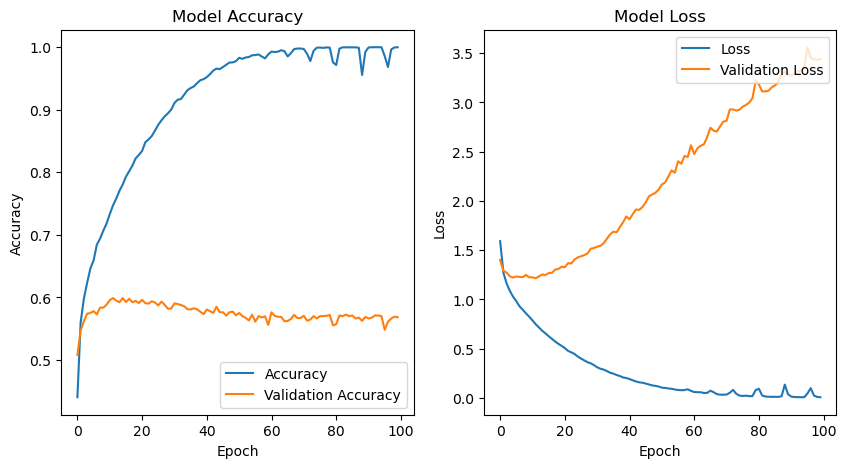

In [188]:
plot_training_accuracy_loss(single_layer_model_history)

Run the model on the test set and display the confusion matrix

Test accuracy: 0.559499979019165
Test loss: 3.3900132179260254
313/313 [==============================] - 0s 1ms/step


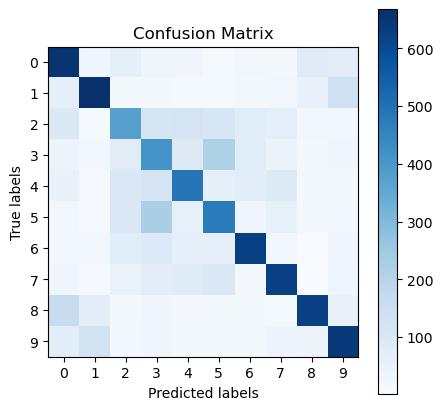

In [192]:
test_model(single_layer_model)

It is clear that the model is overfitting the training data because the validation loss begins to increase after about 10 epochs and the training accuracy approaches 1.0. Later, regularisation will be explored to reduce overfitting. First, lets compare the performance of the model with different activation functions.

### Compare with different activation functions

In order to compare the performance of the model with different activation functions, we will create a model for each activation function and train it for 100 epochs. Then, the validation accuracy will be plotted for each model so that they can be compared.

Epoch 1/100
1250/1250 [==============================] - 3s 2ms/step - loss: 1.5042 - accuracy: 0.4707 - val_loss: 1.3068 - val_accuracy: 0.5355
Epoch 2/100
1250/1250 [==============================] - 3s 2ms/step - loss: 1.2266 - accuracy: 0.5745 - val_loss: 1.2534 - val_accuracy: 0.5631
Epoch 3/100
1250/1250 [==============================] - 3s 2ms/step - loss: 1.0914 - accuracy: 0.6237 - val_loss: 1.2222 - val_accuracy: 0.5786
Epoch 4/100
1250/1250 [==============================] - 3s 2ms/step - loss: 0.9705 - accuracy: 0.6660 - val_loss: 1.2435 - val_accuracy: 0.5714
Epoch 5/100
1250/1250 [==============================] - 3s 2ms/step - loss: 0.8755 - accuracy: 0.6979 - val_loss: 1.1844 - val_accuracy: 0.5969
Epoch 6/100
1250/1250 [==============================] - 3s 2ms/step - loss: 0.7894 - accuracy: 0.7291 - val_loss: 1.2495 - val_accuracy: 0.5893
Epoch 7/100
1250/1250 [==============================] - 3s 2ms/step - loss: 0.7199 - accuracy: 0.7539 - val_loss: 1.2630 - val_ac

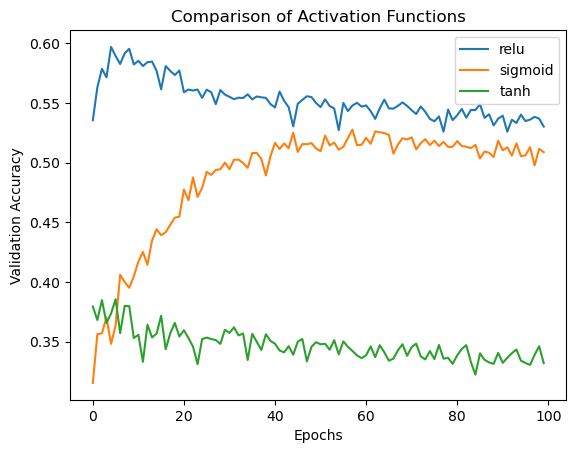

In [38]:
# Create a list of activation functions to compare
activation_functions = ['relu', 'sigmoid', 'tanh']

# Create a model for each activation function and train it for 100 epochs, then plot the validation accuracy
for activation in activation_functions:
    model = Sequential([
        Conv2D(32, (3, 3), activation=activation, input_shape=(32, 32, 3)),
        Flatten(),
        Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    history = model.fit(x_train, y_train, epochs=100, validation_data=(x_test, y_test))
    plt.plot(history.history['val_accuracy'], label=activation)

plt.title('Comparison of Activation Functions')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.show()

The graph shows that the ReLU activation function performs better than the sigmoid and tanh activation functions as the validation accuracy is higher acoss all epochs. ReLU is generally considered to be better than sigmoid and tanh for image classification as it computationally efficient and avoids the vanishing gradient problem, although it will be worth performing this comparison on other models to see if ReLU is consistently the better performing activation function.

### Compare with different optimisers

Epoch 1/100
1250/1250 [==============================] - 3s 2ms/step - loss: 1.4894 - accuracy: 0.4756 - val_loss: 1.3295 - val_accuracy: 0.5359
Epoch 2/100
1250/1250 [==============================] - 3s 2ms/step - loss: 1.2118 - accuracy: 0.5805 - val_loss: 1.2486 - val_accuracy: 0.5653
Epoch 3/100
1250/1250 [==============================] - 3s 2ms/step - loss: 1.0768 - accuracy: 0.6256 - val_loss: 1.2566 - val_accuracy: 0.5650
Epoch 4/100
1250/1250 [==============================] - 3s 2ms/step - loss: 0.9861 - accuracy: 0.6621 - val_loss: 1.2946 - val_accuracy: 0.5629
Epoch 5/100
1250/1250 [==============================] - 3s 2ms/step - loss: 0.8987 - accuracy: 0.6903 - val_loss: 1.2445 - val_accuracy: 0.5828
Epoch 6/100
1250/1250 [==============================] - 3s 2ms/step - loss: 0.8242 - accuracy: 0.7163 - val_loss: 1.2194 - val_accuracy: 0.5960
Epoch 7/100
1250/1250 [==============================] - 3s 2ms/step - loss: 0.7615 - accuracy: 0.7382 - val_loss: 1.3024 - val_ac

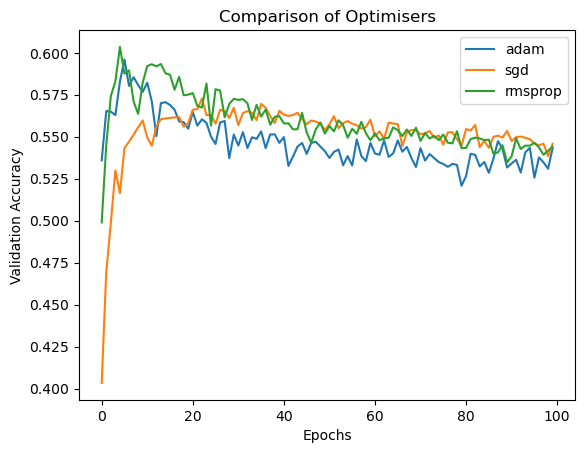

In [39]:
optimisers = ['adam', 'sgd', 'rmsprop']

for optimiser in optimisers:
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
        Flatten(),
        Dense(10, activation='softmax')
    ])
    model.compile(optimizer=optimiser,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    history = model.fit(x_train, y_train, epochs=100, validation_data=(x_test, y_test))
    plt.plot(history.history['val_accuracy'], label=optimiser)

plt.title('Comparison of Optimisers')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.show()

This graph shows that the performance of the model is relatively similar for all optimisers. Throughout the training, each of the optimisers performs better than the others at some point, but the differences are not significant after the first few epochs. Therefore, the Adam optimiser will continue to be used for the rest of the comparisons with this model, although it will be worth performing this comparison on other models to see which optimiser is consistently the best.

## Build a more complex neural network

Create a more complex neural network consisting of 3 convolutional layers with max pooling layers between them, followed by a flatten layer and 2 dense layers.

Model architecture: *TensorFlow. Convolutional Neural Networks (CNN) - TensorFlow Core. [online] Available at: https://www.tensorflow.org/tutorials/images/cnn [Accessed 6 March 2023]*.

- The first convolutional layer has 32 filters of size 3x3, whereas the second and third convolutional layers have 64 filters of size 3x3.
- The max pooling layers inbetween each convolutional layer has a pool size of 2x2.
- The output of the final convolutional layer is flattened and passed to a dense layer with 64 neurons.
- The final dense layer has 10 neurons and a softmax activation function, where each neuron corresponds to a class.

Again, start by using:
- ReLU activation function for the convolutional layers (as it is a good default choice)
- Adam optimiser (as it is a good default choice)

In [10]:
multi_layer_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(10, activation='softmax')
])
multi_layer_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy']
                          )

Train the model for 100 epochs with a batch size of 64 on the training data and evaluate the model on the validation data

In [11]:
history = multi_layer_model.fit(x_train, y_train, batch_size=64, epochs=100, validation_data=(x_val, y_val))

Epoch 1/100
625/625 [==============================] - 5s 4ms/step - loss: 1.6489 - accuracy: 0.3970 - val_loss: 1.4589 - val_accuracy: 0.4710
Epoch 2/100
625/625 [==============================] - 2s 3ms/step - loss: 1.2856 - accuracy: 0.5414 - val_loss: 1.1862 - val_accuracy: 0.5779
Epoch 3/100
625/625 [==============================] - 2s 3ms/step - loss: 1.1317 - accuracy: 0.5998 - val_loss: 1.1101 - val_accuracy: 0.6110
Epoch 4/100
625/625 [==============================] - 2s 3ms/step - loss: 1.0278 - accuracy: 0.6380 - val_loss: 0.9960 - val_accuracy: 0.6503
Epoch 5/100
625/625 [==============================] - 2s 3ms/step - loss: 0.9551 - accuracy: 0.6648 - val_loss: 0.9908 - val_accuracy: 0.6532
Epoch 6/100
625/625 [==============================] - 2s 3ms/step - loss: 0.9014 - accuracy: 0.6837 - val_loss: 0.9366 - val_accuracy: 0.6773
Epoch 7/100
625/625 [==============================] - 2s 3ms/step - loss: 0.8592 - accuracy: 0.6995 - val_loss: 0.9394 - val_accuracy: 0.6725

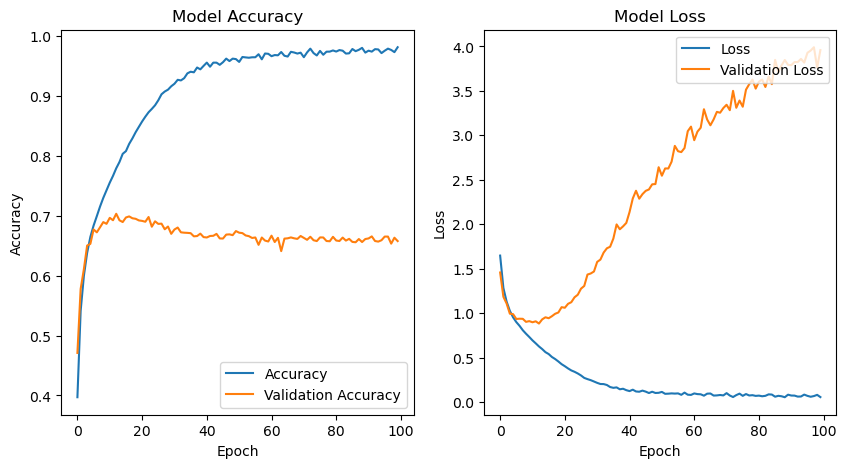

In [12]:
plot_training_accuracy_loss(history)

313/313 - 1s - loss: 3.9208 - accuracy: 0.6624 - 570ms/epoch - 2ms/step
Test accuracy: 0.6624000072479248
Test loss: 3.92082142829895
313/313 [==============================] - 0s 1ms/step


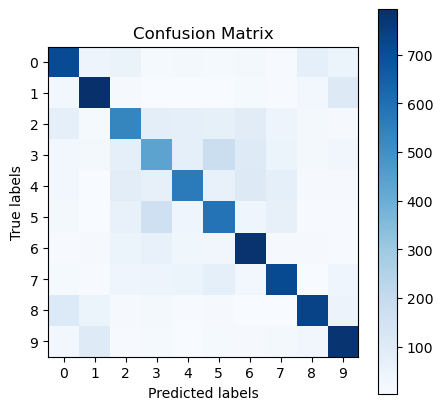

In [13]:
test_model(multi_layer_model)

As expected, this model performs much better than the single layer model, as evidenced by greater test accuracy. However, similar to the single layer model, the model is overfitting the training data. As a result, regularisation will be applied to the model at a later stage - first the different activation functions will be compared.

### Compare different activation functions

For this model, only the activation functions for the convolutional layers will be modified to keep the comparison as consistent as possible. The activation function for the dense layers will remain as ReLU, as it is a good default choice.

Epoch 1/100
1250/1250 [==============================] - 4s 3ms/step - loss: 1.5911 - accuracy: 0.4151 - val_loss: 1.4528 - val_accuracy: 0.4959
Epoch 2/100
1250/1250 [==============================] - 4s 3ms/step - loss: 1.2254 - accuracy: 0.5656 - val_loss: 1.1416 - val_accuracy: 0.5931
Epoch 3/100
1250/1250 [==============================] - 4s 3ms/step - loss: 1.0705 - accuracy: 0.6235 - val_loss: 1.0745 - val_accuracy: 0.6214
Epoch 4/100
1250/1250 [==============================] - 4s 3ms/step - loss: 0.9724 - accuracy: 0.6600 - val_loss: 0.9807 - val_accuracy: 0.6557
Epoch 5/100
1250/1250 [==============================] - 4s 3ms/step - loss: 0.8968 - accuracy: 0.6861 - val_loss: 0.9964 - val_accuracy: 0.6572
Epoch 6/100
1250/1250 [==============================] - 4s 3ms/step - loss: 0.8314 - accuracy: 0.7077 - val_loss: 0.9244 - val_accuracy: 0.6816
Epoch 7/100
1250/1250 [==============================] - 4s 3ms/step - loss: 0.7840 - accuracy: 0.7271 - val_loss: 0.9198 - val_ac

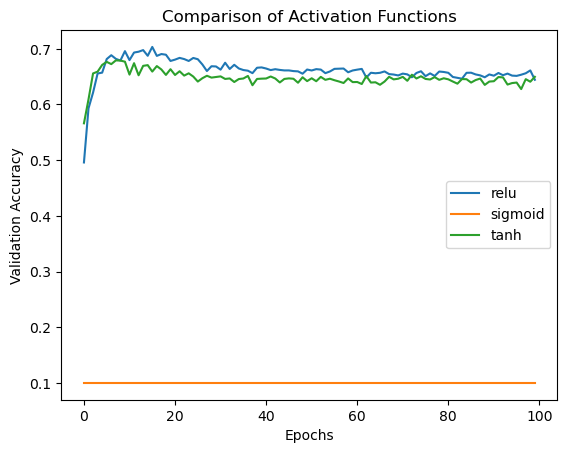

In [14]:
# Create a list of activation functions to compare
activation_functions = ['relu', 'sigmoid', 'tanh']

# Create a model for each activation function and train it for 100 epochs, then plot the validation accuracy
for activation in activation_functions:
    model = Sequential([
        Conv2D(32, (3, 3), activation=activation, input_shape=(32, 32, 3)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation=activation),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation=activation),
        Flatten(),
        Dense(64, activation=activation),
        Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    history = model.fit(x_train, y_train, epochs=100, validation_data=(x_test, y_test))
    plt.plot(history.history['val_accuracy'], label=activation)

plt.title('Comparison of Activation Functions')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.show()

### Compare with different optimisers

In [ ]:
# Create a list of optimisers to compare
optimisers = ['adam', 'sgd', 'rmsprop']

# Create a model for each optimiser and train it for 100 epochs, then plot the validation accuracy
for optimiser in optimisers:
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(10, activation='softmax')
    ])
    model.compile(optimizer=optimiser,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    history = model.fit(x_train, y_train, epochs=100, validation_data=(x_test, y_test))
    plt.plot(history.history['val_accuracy'], label=optimiser)

In [15]:
multi_layer_model_dropout = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    MaxPooling2D((2, 2)),
    Dropout(0.2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.2),
    Conv2D(64, (3, 3), activation='relu'),
    Flatten(),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(10, activation='softmax')
])
multi_layer_model_dropout.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy']
                                  )

## Build a Deep Convolutional Neural Network with VGG architecture

Since we've built a simple CNN and a more complex CNN, let's now build a deep CNN using the VGG architecture which is a popular architecture for image classification. CNN's with VGG architecture consist of a stack of VGG blocks followed by a fully connected layer. A VGG block consists of 2 convolutional layers with 3x3 filters, followed by a max pooling layer with a 2x2 filter.

Architecture taken from: *Simonyan, K., & Zisserman, A. (2015). Very deep convolutional networks for large-scale image recognition. In Proceedings of the International Conference on Learning Representations (ICLR)*.

In [193]:
# Create a function to create a VGG block with a custom number of filters
def VGGBlock(filters=32, activation='relu', input_shape=None):
    if input_shape is None:
        return Sequential([
            Conv2D(filters, (3, 3), activation=activation, padding='same'),
            Conv2D(filters, (3, 3), activation=activation, padding='same'),
            MaxPooling2D((2, 2))
        ])
    else:
        return Sequential([
            Conv2D(filters, (3, 3), activation=activation, padding='same', input_shape=input_shape),
            Conv2D(filters, (3, 3), activation=activation, padding='same'),
            MaxPooling2D((2, 2))
        ])

### Single VGG Block

The first deep CNN we will build will consist of a single VGG block. The output is flattened and passed to a Dense layer with 128 neurons and a ReLU activation function. The output is then passed to another Dense layer with 10 neurons and a softmax activation function.

In [194]:
vgg_single_block_model = Sequential([
    VGGBlock(filters=32, activation='relu', input_shape=(32, 32, 3)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])
vgg_single_block_model.compile(optimizer='adam',
                               loss='categorical_crossentropy',
                               metrics=['accuracy'])

Train the model for 100 epochs with a batch size of 64 on the training data and evaluate the model on the validation data

Epoch 1/100
625/625 [==============================] - 2s 3ms/step - loss: 1.3994 - accuracy: 0.4977 - val_loss: 1.1889 - val_accuracy: 0.5794
Epoch 2/100
625/625 [==============================] - 2s 3ms/step - loss: 1.0045 - accuracy: 0.6462 - val_loss: 1.0116 - val_accuracy: 0.6490
Epoch 3/100
625/625 [==============================] - 2s 3ms/step - loss: 0.8374 - accuracy: 0.7068 - val_loss: 1.0077 - val_accuracy: 0.6515
Epoch 4/100
625/625 [==============================] - 2s 3ms/step - loss: 0.7223 - accuracy: 0.7463 - val_loss: 0.9681 - val_accuracy: 0.6673
Epoch 5/100
625/625 [==============================] - 2s 3ms/step - loss: 0.6047 - accuracy: 0.7893 - val_loss: 0.9975 - val_accuracy: 0.6748
Epoch 6/100
625/625 [==============================] - 2s 3ms/step - loss: 0.4946 - accuracy: 0.8273 - val_loss: 1.0659 - val_accuracy: 0.6757
Epoch 7/100
625/625 [==============================] - 2s 3ms/step - loss: 0.3859 - accuracy: 0.8655 - val_loss: 1.1544 - val_accuracy: 0.6658

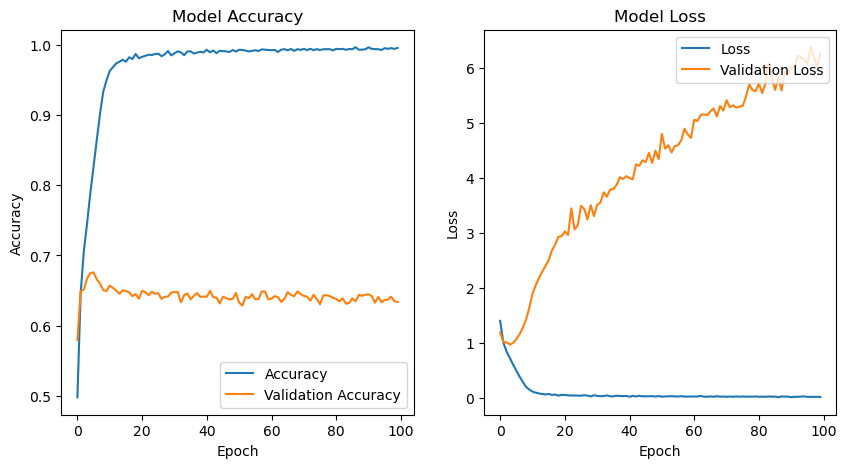

In [195]:
train_history = vgg_single_block_model.fit(x_train, y_train, batch_size=64, epochs=100, validation_data=(x_val, y_val))
plot_training_accuracy_loss(train_history)

Evaluate the model on the test set - the expected accuracy should be much higher than the simple neural network

Test accuracy: 0.6331999897956848
Test loss: 6.21121883392334
313/313 [==============================] - 0s 1ms/step


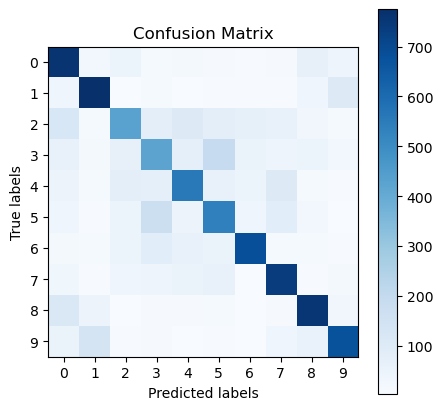

In [196]:
test_model(vgg_single_block_model)

As expected, the accuracy is higher than the simple neural network. This is reflected in the confusion matrix, where the model is much better at predicting the correct class for each image (the diagonal is much lighter than the simple neural network's confusion matrix). However, the model is rapidly overfitting the validation data set after a few epochs which may be because the model is too complex for the small dataset.

### Double VGG Block

Lets try adding another VGG block with 64 filters to the model and see how it affects the accuracy.

In [17]:
vgg_double_block_model = Sequential([
    VGGBlock(filters=32, activation='relu', input_shape=(32, 32, 3)),
    VGGBlock(filters=64, activation='relu'),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])
vgg_double_block_model.compile(optimizer='adam',
                               loss='categorical_crossentropy',
                               metrics=['accuracy'])

Epoch 1/100
625/625 [==============================] - 3s 4ms/step - loss: 1.4769 - accuracy: 0.4645 - val_loss: 1.2035 - val_accuracy: 0.5708
Epoch 2/100
625/625 [==============================] - 2s 4ms/step - loss: 1.0151 - accuracy: 0.6425 - val_loss: 0.9418 - val_accuracy: 0.6740
Epoch 3/100
625/625 [==============================] - 3s 4ms/step - loss: 0.8211 - accuracy: 0.7134 - val_loss: 0.8713 - val_accuracy: 0.6966
Epoch 4/100
625/625 [==============================] - 3s 4ms/step - loss: 0.6967 - accuracy: 0.7587 - val_loss: 0.8353 - val_accuracy: 0.7111
Epoch 5/100
625/625 [==============================] - 2s 4ms/step - loss: 0.5861 - accuracy: 0.7929 - val_loss: 0.8426 - val_accuracy: 0.7169
Epoch 6/100
625/625 [==============================] - 3s 4ms/step - loss: 0.4777 - accuracy: 0.8338 - val_loss: 0.8520 - val_accuracy: 0.7210
Epoch 7/100
625/625 [==============================] - 2s 4ms/step - loss: 0.3869 - accuracy: 0.8628 - val_loss: 0.9001 - val_accuracy: 0.7249

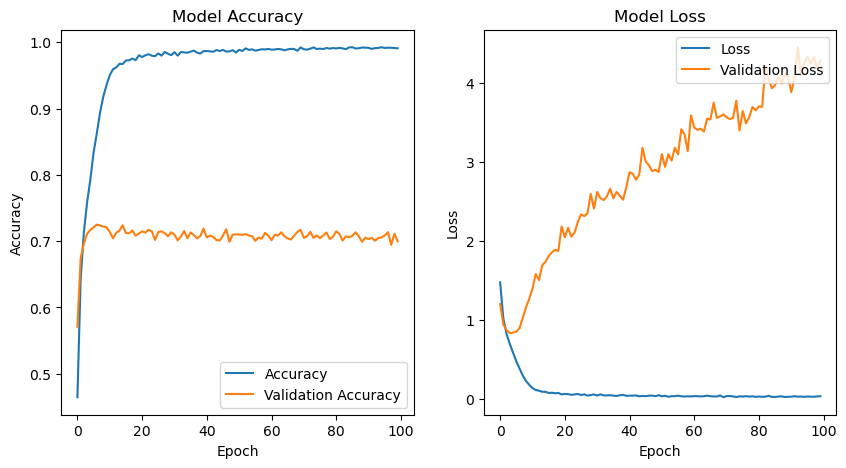

In [18]:
train_history = vgg_double_block_model.fit(x_train, y_train, batch_size=64, epochs=100,
                                           validation_data=(x_test, y_test))
plot_training_accuracy_loss(train_history)

313/313 - 1s - loss: 4.2870 - accuracy: 0.6997 - 618ms/epoch - 2ms/step
Test accuracy: 0.6996999979019165
Test loss: 4.286960601806641
313/313 [==============================] - 0s 1ms/step


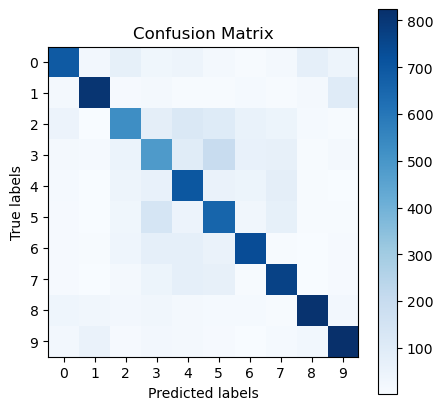

In [19]:
test_model(vgg_double_block_model)

The accuracy has improved by a reasonable amount over the single VGG block model, so it is plausible that adding another VGG block will improve the accuracy even further. This time, lets add a block with 128 filters.

### Triple VGG Block

In [20]:
vgg_triple_block_model = Sequential([
    VGGBlock(filters=32, activation='relu', input_shape=(32, 32, 3)),
    VGGBlock(filters=64, activation='relu'),
    VGGBlock(filters=128, activation='relu'),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])
vgg_triple_block_model.compile(optimizer='adam',
                               loss='categorical_crossentropy',
                               metrics=['accuracy'])

482/625 [======================>.......] - ETA: 0s - loss: 0.0664 - accuracy: 0.9792

Epoch 1/100
625/625 [==============================] - 4s 5ms/step - loss: 1.6521 - accuracy: 0.3904 - val_loss: 1.2754 - val_accuracy: 0.5402
Epoch 2/100
625/625 [==============================] - 3s 5ms/step - loss: 1.1391 - accuracy: 0.5894 - val_loss: 1.0132 - val_accuracy: 0.6403
Epoch 3/100
625/625 [==============================] - 3s 5ms/step - loss: 0.9069 - accuracy: 0.6804 - val_loss: 0.9073 - val_accuracy: 0.6830
Epoch 4/100
625/625 [==============================] - 3s 5ms/step - loss: 0.7561 - accuracy: 0.7337 - val_loss: 0.8192 - val_accuracy: 0.7154
Epoch 5/100
625/625 [==============================] - 3s 5ms/step - loss: 0.6427 - accuracy: 0.7718 - val_loss: 0.7745 - val_accuracy: 0.7363
Epoch 6/100
625/625 [==============================] - 3s 5ms/step - loss: 0.5411 - accuracy: 0.8108 - val_loss: 0.7653 - val_accuracy: 0.7448
Epoch 7/100
625/625 [==============================] - 3s 5ms/step - loss: 0.4617 - accuracy: 0.8367 - val_loss: 0.8029 - val_accuracy: 0.7381

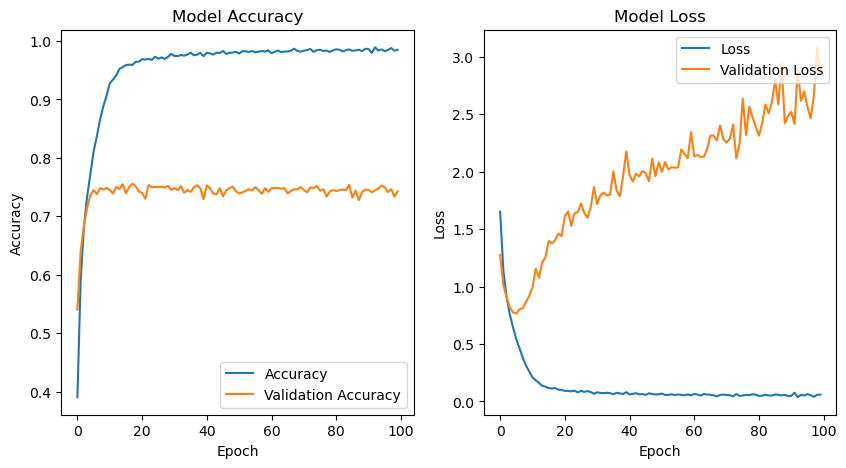

In [21]:
train_history = vgg_triple_block_model.fit(x_train, y_train, batch_size=64, epochs=100,
                                           validation_data=(x_test, y_test))
plot_training_accuracy_loss(train_history)

313/313 - 1s - loss: 2.8492 - accuracy: 0.7427 - 705ms/epoch - 2ms/step
Test accuracy: 0.7426999807357788
Test loss: 2.849238157272339
313/313 [==============================] - 1s 2ms/step


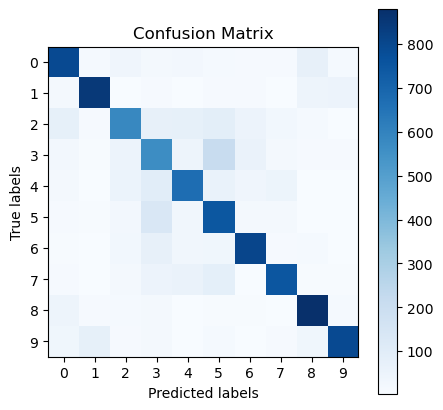

In [22]:
test_model(vgg_triple_block_model)

The accuracy has improved over the double VGG block model, but not by as much as the difference between the single and double VGG block nmodels. It is therefore plausible that adding more VGG blocks will not necessarily improve the accuracy of the model i.e. we will reach a threshold where adding more VGG blocks will not improve the accuracy of the model. Instead, we can see that all of the models were rapidly overfitting the training data after 5-10 epochs, so we can next explore different types of regularisation to prevent this.

### Model Regularisation

In each of the graphs displaying the loss of each model, the validation loss is shown to decrease for several epochs before rapidly increasing again. This signals that the model is overfitting the training data which means we need to add regularisation to the model. In this section, we will explore different types of regularisation on the triple VGG block model and compare the results.

The different types of regularisation that will be compared are: dropout regularisation, batch normalisation and data augmentation.

The first type that will be explored is dropout regularisation which is a technique where neurons are selected at random and dropped out of the network during training. This reduces the chance of overfitting by preventing the model from relying on specific neurons. Increasing the dropout rate in each VGG block will be explored to see how it affects the accuracy of the model.

In [29]:
vgg_triple_block_model_dropout = Sequential([
    VGGBlock(filters=32, activation='relu', input_shape=(32, 32, 3)),
    Dropout(0.2),
    VGGBlock(filters=64, activation='relu'),
    Dropout(0.3),
    VGGBlock(filters=128, activation='relu'),
    Dropout(0.4),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])
vgg_triple_block_model_dropout.compile(optimizer='adam',
                               loss='categorical_crossentropy',
                               metrics=['accuracy'])

Epoch 1/100
625/625 [==============================] - 4s 6ms/step - loss: 1.7112 - accuracy: 0.3638 - val_loss: 1.3842 - val_accuracy: 0.4936
Epoch 2/100
625/625 [==============================] - 3s 6ms/step - loss: 1.2711 - accuracy: 0.5356 - val_loss: 1.1335 - val_accuracy: 0.5942
Epoch 3/100
625/625 [==============================] - 3s 6ms/step - loss: 1.0995 - accuracy: 0.6037 - val_loss: 1.0256 - val_accuracy: 0.6352
Epoch 4/100
625/625 [==============================] - 3s 5ms/step - loss: 0.9991 - accuracy: 0.6437 - val_loss: 0.9238 - val_accuracy: 0.6756
Epoch 5/100
625/625 [==============================] - 3s 5ms/step - loss: 0.9210 - accuracy: 0.6736 - val_loss: 0.8632 - val_accuracy: 0.6974
Epoch 6/100
625/625 [==============================] - 3s 5ms/step - loss: 0.8648 - accuracy: 0.6923 - val_loss: 0.7731 - val_accuracy: 0.7280
Epoch 7/100
625/625 [==============================] - 3s 5ms/step - loss: 0.8111 - accuracy: 0.7136 - val_loss: 0.7914 - val_accuracy: 0.7247

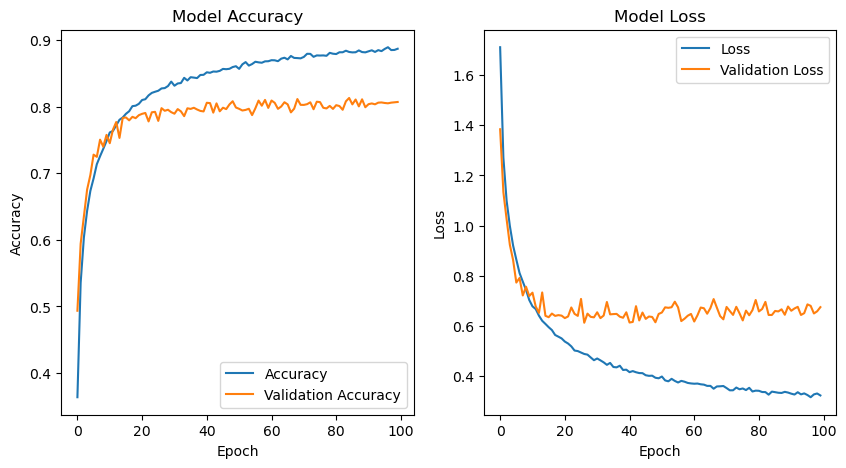

In [30]:
train_history = vgg_triple_block_model_dropout.fit(x_train, y_train, batch_size=64, epochs=100,
                                               validation_data=(x_test, y_test))
plot_training_accuracy_loss(train_history)

313/313 - 1s - loss: 0.6752 - accuracy: 0.8071 - 677ms/epoch - 2ms/step
Test accuracy: 0.8070999979972839
Test loss: 0.6751599311828613
313/313 [==============================] - 1s 2ms/step


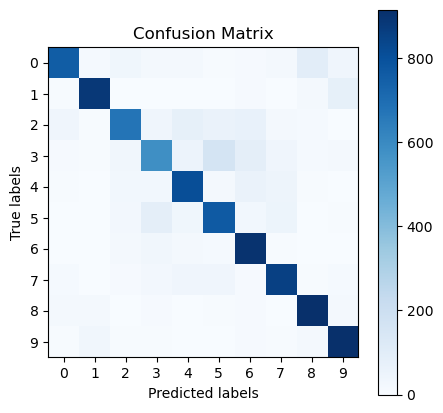

In [31]:
test_model(vgg_triple_block_model_dropout)

As can be seen from the test accuracy, regularisation via dropout has improved the performance of the model. This is also reflected in the confusion matrix, where the diagonal line is lighter than before. There is much less overfitting of the training data too because the validation loss is much lower than before.

Let's create a triple VGG block model with batch normalisation and compare the results.

In [51]:
from tensorflow.keras.layers import BatchNormalization

def VGGBlockBatchNormalisation(filters, activation, input_shape=None):
    if input_shape is None:
        return Sequential([
            Conv2D(filters=filters, kernel_size=(3, 3), padding='same', activation=activation),
            BatchNormalization(),
            Conv2D(filters=filters, kernel_size=(3, 3), padding='same', activation=activation),
            BatchNormalization(),
            MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
        ])
    else:
        return Sequential([
            Conv2D(filters=filters, kernel_size=(3, 3), padding='same', activation=activation, input_shape=input_shape),
            BatchNormalization(),
            Conv2D(filters=filters, kernel_size=(3, 3), padding='same', activation=activation),
            BatchNormalization(),
            MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
        ])

In [52]:
vgg_triple_block_batch_normalisation = Sequential([
    VGGBlockBatchNormalisation(filters=32, activation='relu', input_shape=(32, 32, 3)),
    VGGBlockBatchNormalisation(filters=64, activation='relu'),
    VGGBlockBatchNormalisation(filters=128, activation='relu'),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])
vgg_triple_block_batch_normalisation.compile(optimizer='adam',
                                       loss='categorical_crossentropy',
                                       metrics=['accuracy'])

Epoch 1/100
625/625 [==============================] - 5s 7ms/step - loss: 1.3099 - accuracy: 0.5379 - val_loss: 1.1146 - val_accuracy: 0.6077
Epoch 2/100
625/625 [==============================] - 4s 6ms/step - loss: 0.8290 - accuracy: 0.7085 - val_loss: 0.9547 - val_accuracy: 0.6691
Epoch 3/100
625/625 [==============================] - 4s 7ms/step - loss: 0.6390 - accuracy: 0.7760 - val_loss: 0.7154 - val_accuracy: 0.7560
Epoch 4/100
625/625 [==============================] - 4s 6ms/step - loss: 0.5184 - accuracy: 0.8181 - val_loss: 0.8617 - val_accuracy: 0.7155
Epoch 5/100
625/625 [==============================] - 4s 6ms/step - loss: 0.4131 - accuracy: 0.8564 - val_loss: 0.8467 - val_accuracy: 0.7426
Epoch 6/100
625/625 [==============================] - 4s 6ms/step - loss: 0.3186 - accuracy: 0.8886 - val_loss: 0.7682 - val_accuracy: 0.7637
Epoch 7/100
625/625 [==============================] - 4s 6ms/step - loss: 0.2359 - accuracy: 0.9191 - val_loss: 0.8892 - val_accuracy: 0.7643

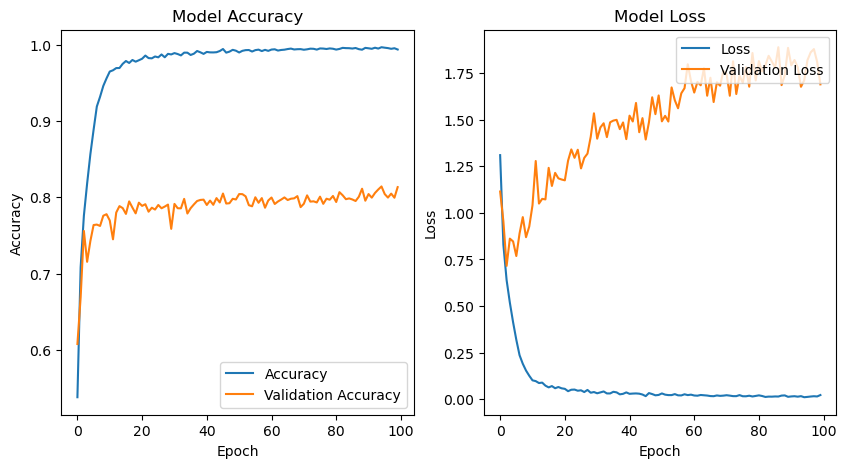

In [53]:
train_history = vgg_triple_block_batch_normalisation.fit(x_train, y_train, batch_size=64, epochs=100,
                                                   validation_data=(x_test, y_test))
plot_training_accuracy_loss(train_history)

313/313 - 1s - loss: 1.6900 - accuracy: 0.8134 - 726ms/epoch - 2ms/step
Test accuracy: 0.8133999705314636
Test loss: 1.6899714469909668
313/313 [==============================] - 1s 2ms/step


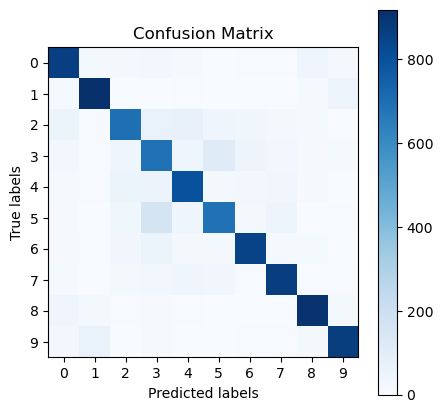

In [54]:
test_model(vgg_triple_block_batch_normalisation)

Similar to dropout regularisation, batch normalisation has improved the performance of the model as the test accuracy is higher. The level of overfitting has been reduced as the validation loss is lower than before, although it is still higher than the dropout regularisation model, therefore something that may be worth exploring later is a combination of dropout and batch normalisation.

The final type of regularisation that will be explored is data augmentation. This is a technique where the training data is artificially expanded by applying random transformations to the images to prevent the model from overfitting the training data. The transformations that will be applied are: rotation, width shift, height shift and horizontal flip using the ImageDataGenerator class from Keras.

In [197]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_generator = ImageDataGenerator(
    rotation_range=20,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1,
)

In [198]:
vgg_triple_block_data_augmentation = Sequential([
    VGGBlock(filters=32, activation='relu', input_shape=(32, 32, 3)),
    VGGBlock(filters=64, activation='relu'),
    VGGBlock(filters=128, activation='relu'),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])
vgg_triple_block_data_augmentation.compile(optimizer='adam',
                                       loss='categorical_crossentropy',
                                       metrics=['accuracy'])

Epoch 1/100
625/625 [==============================] - 13s 21ms/step - loss: 1.7091 - accuracy: 0.3640 - val_loss: 1.3770 - val_accuracy: 0.4901
Epoch 2/100
625/625 [==============================] - 12s 19ms/step - loss: 1.3307 - accuracy: 0.5165 - val_loss: 1.1205 - val_accuracy: 0.6019
Epoch 3/100
625/625 [==============================] - 12s 19ms/step - loss: 1.1286 - accuracy: 0.5954 - val_loss: 1.0026 - val_accuracy: 0.6534
Epoch 4/100
625/625 [==============================] - 12s 19ms/step - loss: 1.0002 - accuracy: 0.6446 - val_loss: 0.9038 - val_accuracy: 0.6851
Epoch 5/100
625/625 [==============================] - 12s 19ms/step - loss: 0.9011 - accuracy: 0.6822 - val_loss: 0.8833 - val_accuracy: 0.6989
Epoch 6/100
625/625 [==============================] - 12s 19ms/step - loss: 0.8502 - accuracy: 0.7032 - val_loss: 0.8549 - val_accuracy: 0.7109
Epoch 7/100
625/625 [==============================] - 12s 19ms/step - loss: 0.8050 - accuracy: 0.7181 - val_loss: 0.8257 - val_ac

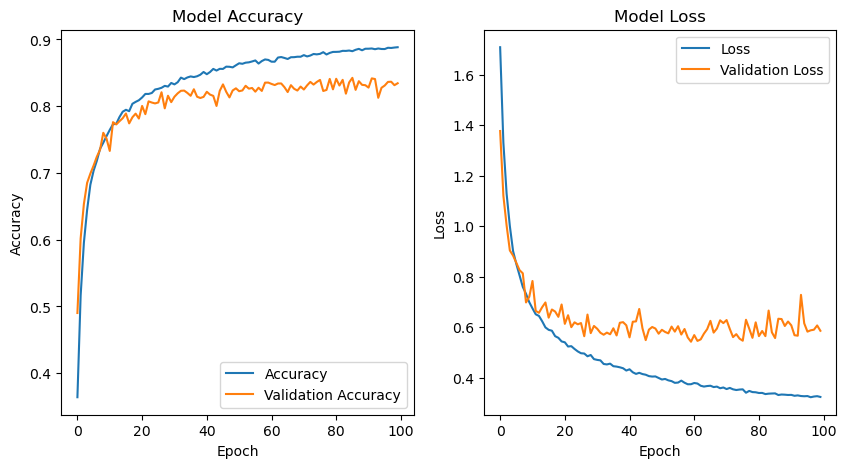

In [199]:
train_history = vgg_triple_block_data_augmentation.fit(data_generator.flow(x_train, y_train, batch_size=64), epochs=100,
                                                 validation_data=(x_test, y_test))
plot_training_accuracy_loss(train_history)

Test accuracy: 0.8342999815940857
Test loss: 0.5854270458221436
313/313 [==============================] - 1s 2ms/step


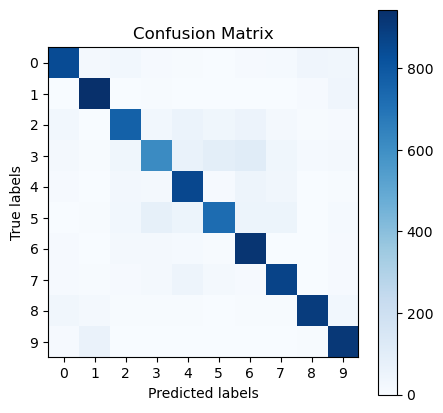

In [200]:
test_model(vgg_triple_block_data_augmentation)

Data augmentation has also improved the performance of the model. The level of overfitting has been reduced as the validation loss doesn't consistently increase as the training loss decreases.

Since all three types of regularisation have improved the performance of the model, it is worth exploring a model that uses all three types of regularisation.

In [201]:
vgg_triple_block_all_regularisation = Sequential([
    VGGBlockBatchNormalisation(filters=32, activation='relu', input_shape=(32, 32, 3)),
    Dropout(0.2),
    VGGBlockBatchNormalisation(filters=64, activation='relu'),
    Dropout(0.3),
    VGGBlockBatchNormalisation(filters=128, activation='relu'),
    Dropout(0.4),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])
vgg_triple_block_all_regularisation.compile(optimizer='adam',
                                       loss='categorical_crossentropy',
                                       metrics=['accuracy'])

In [202]:
train_history = vgg_triple_block_all_regularisation.fit(data_generator.flow(x_train, y_train, batch_size=64), epochs=100,
                                                 validation_data=(x_test, y_test))
plot_training_accuracy_loss(train_history)

Epoch 1/100
625/625 [==============================] - 13s 20ms/step - loss: 1.6941 - accuracy: 0.3879 - val_loss: 1.4730 - val_accuracy: 0.4719
Epoch 2/100
625/625 [==============================] - 12s 20ms/step - loss: 1.3165 - accuracy: 0.5243 - val_loss: 1.4737 - val_accuracy: 0.5260
Epoch 3/100
625/625 [==============================] - 12s 20ms/step - loss: 1.1392 - accuracy: 0.5925 - val_loss: 1.1416 - val_accuracy: 0.6177
Epoch 4/100
625/625 [==============================] - 13s 20ms/step - loss: 1.0235 - accuracy: 0.6366 - val_loss: 1.0932 - val_accuracy: 0.6285
Epoch 5/100
625/625 [==============================] - 12s 20ms/step - loss: 0.9499 - accuracy: 0.6642 - val_loss: 1.1015 - val_accuracy: 0.6411
Epoch 6/100
625/625 [==============================] - 12s 20ms/step - loss: 0.8969 - accuracy: 0.6870 - val_loss: 0.9618 - val_accuracy: 0.6790
Epoch 7/100
625/625 [==============================] - 12s 20ms/step - loss: 0.8551 - accuracy: 0.7021 - val_loss: 0.8250 - val_ac

Test accuracy: 0.8743000030517578
Test loss: 0.39426207542419434
313/313 [==============================] - 1s 2ms/step


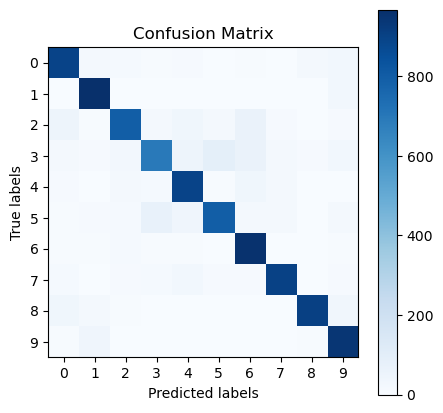

In [203]:
test_model(vgg_triple_block_all_regularisation)

As can be seen from the training and validation loss graph, this model is no longer overfitting the training data due to the combination of several regularisation techniques. The test accuracy is also higher than the other models, as reflected in the confusion matrix.